---
# 1.1 Scientific computing
---

## Motivation

- Computers have become a central tool that is used in virtually every discipline:  

    - mathematics
    - engineering
    - physical sciences
    - social sciences
    - economics
    - data science
    - ...

- In these disciplines, **mathematical models** are used to explore and gain a deeper understanding of complex systems.

- There will always be a need for those with the ability to develop and use software that can _efficiently_, _accurately_, and _reliably_ solve mathematical models.

## Overview

In this class, we will learn computational methods (algorithms) for working with _continuous_ mathematical models:
    
| Chapter | Topic |
|:--------:|-------|
|  3 | Nonlinear Equations in One Variable |
| 10 | Polynomial Interpolation |
| 11 | Piecewise Polynomial Interpolation |
| 12 | Best Approximation |
| 14 | Numerical Differentiation |
| 15 | Numerical Integration |
| 16 | Differential Equations |

## Goals

Learning these algorithms will give you the knowledge and skills to solve more complex problems you may encounter in your careers. We will study:

1. The theory behind the algorithms (numerical analysis):
    - complexity and convergence rate
    - problem conditioning and algorithm stability
    - accuracy and error bounds
    - proofs
2. How to choose which method should be used for a particular problem.
3. How to implement the method efficiently.
    - We will use [Julia](http://julialang.org): "a high-level, high-performance dynamic programming language for technical computing."
    - See [Julia benchmarks](http://julialang.org/benchmarks/) for a comparison with various other languages.
4. How to evaluate and test your implementation for *efficiency*, *accuracy*, and *robustness*.

---
# Section 1.2: Numerical algorithms and errors
---

Suppose some quantity $u$ is approximated by $v$. The **absolute error** is measured by

$$
|u - v|.
$$

Often, it is better to look at how large $|u-v|$ is compared to $|u|$. If $|u-v|$ is $p$ percent of $|u|$, then 

$$
|u-v| = p|u|.
$$ 

If $u \ne 0$, then
$$
p = \frac{|u-v|}{|u|},
$$
which is called the **relative error**.

In [1]:
u, v = π, 3.14159
#u = π
#v = 3.14159

(π, 3.14159)

In [2]:
u

π = 3.1415926535897...

In [3]:
v

3.14159

In [4]:
typeof(u)

Irrational{:π}

In [5]:
typeof(v)

Float64

In [6]:
abs(u - v)

2.6535897932333796e-6

i.e., $\approx 2.6 \times 10^{-6}$

In [7]:
p = abs(u - v)/abs(u)

8.446638650625857e-7

i.e., $\approx 8.4 \times 10^{-7} = (8.4 \times 10^{-5})\%$

In [8]:
# Number of digits of accuracy
-log10(p)

6.0733160846496

In [9]:
?abs

search: abs abs2 ans as acsc axes acos



```
abs(x)
```

The absolute value of `x`.

When `abs` is applied to signed integers, overflow may occur, resulting in the return of a negative value. This overflow occurs only when `abs` is applied to the minimum representable value of a signed integer. That is, when `x == typemin(typeof(x))`, `abs(x) == x < 0`, not `-x` as might be expected.

See also: [`abs2`](@ref), [`unsigned`](@ref), [`sign`](@ref).

# Examples

```jldoctest
julia> abs(-3)
3

julia> abs(1 + im)
1.4142135623730951

julia> abs.(Int8[-128 -127 -126 0 126 127])  # overflow at typemin(Int8)
1×6 Matrix{Int8}:
 -128  127  126  0  126  127

julia> maximum(abs, [1, -2, 3, -4])
4
```


---

## Exercise
Complete the following table.

| $u$ | $v$ | absolute error | relative error |
|:---:|:---:|:--------------:|:--------------:|
|   1 |  0.99 | 0.01 | 0.01 |
|   1 |  1.5  | 0.5 | 0.5 |
| 100 | 99.99 | 0.01 | 0.0001 |
| 100 | 100.5 | 0.5  | 0.005 |

In [10]:
abs(1 - 0.99)

0.010000000000000009

In [11]:
abs(1 - 0.99)/abs(1)

0.010000000000000009

In [12]:
abs(1 - 1.5)

0.5

In [13]:
abs(1 - 1.5)/abs(1)

0.5

In [14]:
abs(100 - 99.99)

0.010000000000005116

In [15]:
abs(100 - 99.99)/abs(100)

0.00010000000000005117

In [16]:
abs(100 - 100.5)

0.5

In [17]:
abs(100 - 100.5)/abs(100)

0.005

In [18]:
typeof(99.99)

Float64

---

## Error types

1. Errors in mathematical model or in the data
2. Approximation errors
3. Roundoff errors
    - due to the finite precision of real numbers stored on a computer

## Approximation Error (approximating the derivative)

Consider the formula for the derivative of a differentiable function $f \colon \mathbb{R} \to \mathbb{R}$ at $x_0$:

$$ f'(x_0) = \lim_{h \to 0} \frac{f(x_0 + h) - f(x_0)}{h}.$$

It is therefore reasonable to approximate $f'(x_0)$ using

$$\frac{f(x_0 + h) - f(x_0)}{h}$$

for some small positive $h$. The error in this approximation is 

$$\left|f'(x_0) - \frac{f(x_0 + h) - f(x_0)}{h}\right|$$

and is called a **discretization error**.

---

## Example

Let's computationally examine this approximation error using

$$
f(x) = \sin(x) \quad \text{and} \quad x_0 = 1.
$$

Note that $f'(x) = \cos(x)$.

In [19]:
f(x) = sin(x)

f (generic function with 1 method)

Another way to define the function $f$ in Julia:
```julia
function f(x)
    return sin(x)
end
```

In [20]:
x0 = 1.0
fp = cos(x0)

0.5403023058681398

Thus 

$$f'(x_0) = \cos(1) = 0.5403023058681398\ldots.$$ 

Let's write some **Julia** code to approximate this value using 

$$ 
f'(x_0) \approx \frac{f(x_0 + h) - f(x_0)}{h}
$$

for $h = 10^{-1},10^{-2},\ldots,10^{-16}$.

In [21]:
using Printf

function deriv_approx(f, x0, fp)
    @printf("%6s %24s %12s %10s %8s\n", "h", "fpapprox", "abserr", "relerr", "digits")

    for k in 1:16
        h = 10.0^(-k)
        fpapprox = (f(x0+h) - f(x0))/h
        abserr = abs(fp - fpapprox)
        relerr = abserr/abs(fp)
        digits = -log10(relerr)
        @printf("%6.0e %24.16e %12.4e %10.2e %8.1f\n", h, fpapprox, abserr, relerr, digits)
    end
    
    return nothing
end

deriv_approx(f, 1.0, cos(1.0))

     h                 fpapprox       abserr     relerr   digits
 1e-01   4.9736375253538911e-01   4.2939e-02   7.95e-02      1.1
 1e-02   5.3608598101186888e-01   4.2163e-03   7.80e-03      2.1
 1e-03   5.3988148036032690e-01   4.2083e-04   7.79e-04      3.1
 1e-04   5.4026023141862112e-01   4.2074e-05   7.79e-05      4.1
 1e-05   5.4029809850586474e-01   4.2074e-06   7.79e-06      5.1
 1e-06   5.4030188512133037e-01   4.2075e-07   7.79e-07      6.1
 1e-07   5.4030226404044868e-01   4.1828e-08   7.74e-08      7.1
 1e-08   5.4030230289825454e-01   2.9699e-09   5.50e-09      8.3
 1e-09   5.4030235840940577e-01   5.2541e-08   9.72e-08      7.0
 1e-10   5.4030224738710331e-01   5.8481e-08   1.08e-07      7.0
 1e-11   5.4030113716407868e-01   1.1687e-06   2.16e-06      5.7
 1e-12   5.4034554608506369e-01   4.3240e-05   8.00e-05      4.1
 1e-13   5.3956838996782608e-01   7.3392e-04   1.36e-03      2.9
 1e-14   5.4400928206632670e-01   3.7070e-03   6.86e-03      2.2
 1e-15   5.55111512312578

In [22]:
fp

0.5403023058681398

In [23]:
(sin(1.0 + 1e-16) - sin(1.0))/1e-16

0.0

---

 ## Theorem: (Taylor Series)

Assume that $f$ is a function that is $(k+1)$-differentiable on an interval containing $x_0$ and $x_0 + h$. Then

$$
f(x_0 + h) = f(x_0) + h f'(x_0) + \frac{h^2}{2} f''(x_0) + \cdots + \frac{h^k}{k!} f^{(k)}(x_0) + \frac{h^{k+1}}{(k+1)!} f^{(k+1)}(\xi),
$$

for some $\xi \in (x_0, x_0 + h)$.

### Proof that the discretization error decreases at the same rate as $h$:

Solving for $f'(x_0)$ in the Taylor series expansion, we get

$$
f'(x_0) = \frac{f(x_0+h)-f(x_0)}{h} - \left(\frac{h}{2} f''(x_0) + \frac{h^2}{6} f'''(x_0)  + \cdots + \frac{h^{k-1}}{k!} f^{(k)}(\xi)\right).
$$

Therefore,

$$
\left|f'(x_0) - \frac{f(x_0+h)-f(x_0)}{h}\right| = \left|\frac{h}{2} f''(x_0) + \frac{h^2}{6} f'''(x_0) + \cdots + \frac{h^{k-1}}{k!} f^{(k)}(\xi)\right|.
$$

If $f''(x_0) \neq 0$ and $h$ is small, then the right-hand-side is dominated by $\frac{h}{2} f''(x_0)$. Thus,

$$
\left|f'(x_0) - \frac{f(x_0+h)-f(x_0)}{h}\right| \approx \frac{h}{2}\left| f''(x_0)\right| = \mathcal{O}(h). \quad \blacksquare
$$

(See p. 7 of Ascher-Greif for the rigorous definitions of Big-$\mathcal{O}$ and $\Theta$ notation).

## Example continued...

Recall that $f(x) = \sin(x)$. Thus $f''(x) = -\sin(x)$.

In [68]:
fpp = -sin(x0)

abs(fpp)/2

0.42073549240394825

Therefore, 
$$
\frac{\left|f''(x_0)\right|}{2} = 0.42073549240394825\ldots,
$$
which agrees very well with our numerical test.

---

## Exercise

What do you think will happen if $f''(x_0) = 0$? Write code to test your hypothesis.

In [24]:
-sin(π)

-0.0

In [25]:
fp = cos(π)

-1.0

In [26]:
deriv_approx(f, π, -1.0)

     h                 fpapprox       abserr     relerr   digits
 1e-01  -9.9833416646828110e-01   1.6658e-03   1.67e-03      2.8
 1e-02  -9.9998333341663281e-01   1.6667e-05   1.67e-05      4.8
 1e-03  -9.9999983333310904e-01   1.6667e-07   1.67e-07      6.8
 1e-04  -9.9999999833421893e-01   1.6658e-09   1.67e-09      8.8
 1e-05  -9.9999999997763800e-01   2.2362e-11   2.24e-11     10.7
 1e-06  -1.0000000000171467e+00   1.7147e-11   1.71e-11     10.8
 1e-07  -9.9999999713877274e-01   2.8612e-09   2.86e-09      8.5
 1e-08  -9.9999998167606097e-01   1.8324e-08   1.83e-08      7.7
 1e-09  -9.9999996027569105e-01   3.9724e-08   3.97e-08      7.4
 1e-10  -9.9999885809357181e-01   1.1419e-06   1.14e-06      5.9
 1e-11  -9.9998783627237964e-01   1.2164e-05   1.22e-05      4.9
 1e-12  -9.9996643590242629e-01   3.3564e-05   3.36e-05      4.5
 1e-13  -9.9797607536349353e-01   2.0239e-03   2.02e-03      2.7
 1e-14  -1.0091587146636705e+00   9.1587e-03   9.16e-03      2.0
 1e-15  -7.65713739785389

In [27]:
fppp = -cos(π)

abs(fppp)/6

0.16666666666666666

---

## Roundoff Error

Numbers are stored in the computer using a finite precision representation. Roughly 16 digits of precision are possible using the 64-bit floating point format.

Whenever an arithmetic operation takes place, the result must be rounded to roughly 16 digits of precision. Such an error is called **roundoff error**.

We can see the effect of roundoff error in our example when $h$ is very small.

---

## Exercise

Use the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package to make a plot of $h$ versus the absolute error in this approximation. What do you observe? Why is this happening?

In [30]:
import Pkg

#Pkg.instantiate()

Pkg.status()

Status `~/Documents/Teaching/NIU/2025/20252_MATH435/20252-lecture-notes/Project.toml`
  [b964fa9f] LaTeXStrings v1.4.0
  [91a5bcdd] Plots v1.40.9
  [1fd47b50] QuadGK v2.11.1


In [31]:
using Plots

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: incompatible header (16))


In [63]:
?logrange

search: logrange Base.LogRange range LinRange



```
logrange(start, stop, length)
logrange(start, stop; length)
```

Construct a specialized array whose elements are spaced logarithmically between the given endpoints. That is, the ratio of successive elements is a constant, calculated from the length.

This is similar to `geomspace` in Python. Unlike `PowerRange` in Mathematica, you specify the number of elements not the ratio. Unlike `logspace` in Python and Matlab, the `start` and `stop` arguments are always the first and last elements of the result, not powers applied to some base.

# Examples

```jldoctest
julia> logrange(10, 4000, length=3)
3-element Base.LogRange{Float64, Base.TwicePrecision{Float64}}:
 10.0, 200.0, 4000.0

julia> ans[2] ≈ sqrt(10 * 4000)  # middle element is the geometric mean
true

julia> range(10, 40, length=3)[2] ≈ (10 + 40)/2  # arithmetic mean
true

julia> logrange(1f0, 32f0, 11)
11-element Base.LogRange{Float32, Float64}:
 1.0, 1.41421, 2.0, 2.82843, 4.0, 5.65685, 8.0, 11.3137, 16.0, 22.6274, 32.0

julia> logrange(1, 1000, length=4) ≈ 10 .^ (0:3)
true
```

See the [`LogRange`](@ref Base.LogRange) type for further details.

See also [`range`](@ref) for linearly spaced points.

!!! compat "Julia 1.11"
    This function requires at least Julia 1.11.



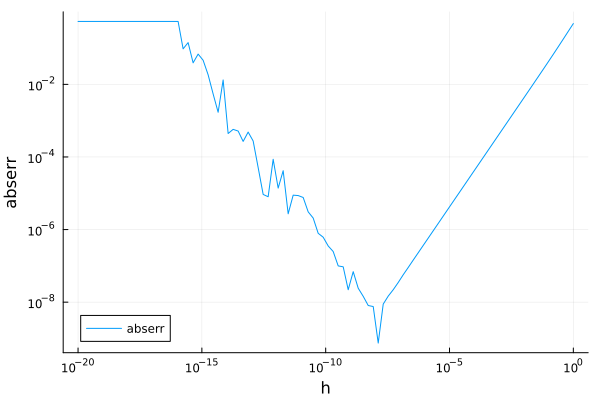

In [69]:
f(x) = sin(x)

x0 = 1.0
fp = cos(x0)

#h = [10.0^(-k) for k in 1:16] # Array comprehension
h = logrange(1e-0, 1e-20, 100)

fpapprox = (f.(x0 .+ h) .- f(x0))./h

#fpapprox = @. (f(x0 + h) - f(x0))/h

abserr = @. abs(fp - fpapprox)

#[h abserr]

plot(h, abserr,
    xaxis=:log,
    yaxis=:log,
    label="abserr",
    legend=:bottomleft,
    xlabel="h",
    ylabel="abserr",
    #title="My title"
)

---
# 1.3 Algorithm properties
---

## Accuracy

As we have seen above, it is easy to write *mathematically correct* code that produces very inaccurate results.

Accuracy is affected by the following two conditions:

1. **Problem conditioning**  
    Some problems are highly sensitive to small changes in the input: we call such problems **ill-conditioned**. A problem that is not sensitive to small changes in the input is called **well-conditioned**. For example, computing $\tan(x)$ for $x$ near $\pi/2$ is an ill-conditioned problem (**Example 1.5** in Ascher-Greif).
2. **Algorithm stability**  
    An algorithm is called **stable** if it is guaranteed to produce an exact answer to a *slightly perturbed problem*. (**Example 1.6** in Ascher-Greif gives an example of an **unstable algorithm**).

In [71]:
π/2

1.5707963267948966

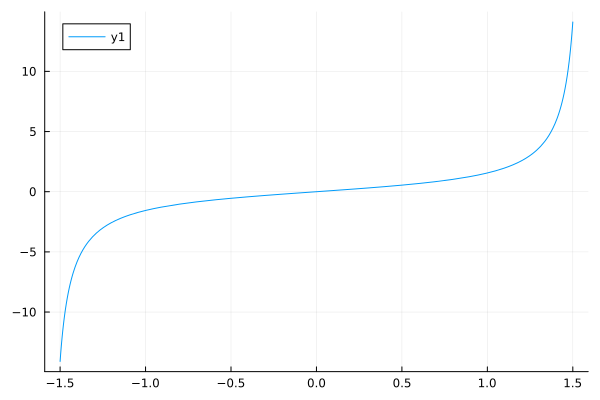

In [72]:
plot(tan, -1.5, 1.5)

In [73]:
tan(π/2 - 1e-1)

9.966644423259222

In [74]:
tan(π/2 - 1e-2)

99.99666664444354

---

## Exercise

Let 

$$ y_n = \int_0^1 \frac{x^n}{x + 10} dx. $$

Then 

$$
y_n + 10y_{n-1} = \int_0^1 \frac{x^n + 10x^{n-1}}{x + 10} dx = \int_0^1 x^{n-1} dx = \frac{1}{n}x^n \Big\rvert_0^1 = \frac1n
$$

and

$$
y_0 = \int_0^1 \frac{1}{x + 10} dx = \ln|x+10| \Big\rvert_0^1 = \ln(11) - \ln(10).
$$

Then use these formulas to numerically compute $y_{30}$.

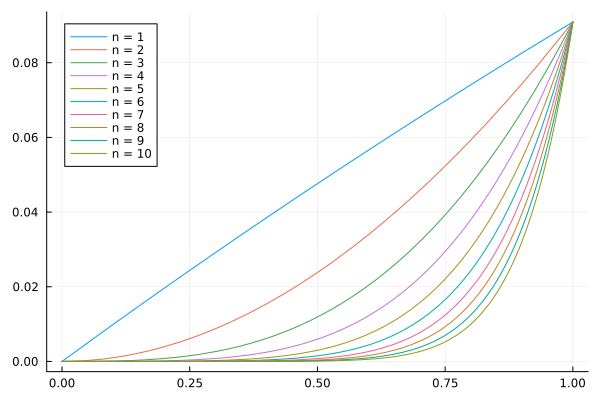

In [83]:
plot()
for n in 1:10
    plot!(x -> x^n/(x+10), 0, 1, label="n = $n")
end
plot!()

In [84]:
using QuadGK

n = 30
integral, error = quadgk(x -> x^n/(x + 10), 0, 1)

(0.002940928704861327, 8.45119305817703e-12)

$$
y_n + 10 y_{n-1} = \frac{1}{n}
$$

$$
y_0 = \ln(11) - \ln(10)
$$

$$
y_n = \frac{1}{n} - 10 y_{n-1}
$$

In [93]:
y0 = log(11) - log(10)

# y1 = 1/1 - 10*y0
# y2 = 1/2 - 10*y1

yvals = zeros(30)
yvals[1] = 1 - 10*y0
for n = 2:30
    yvals[n] = 1/n - 10*yvals[n-1]
end
yvals

30-element Vector{Float64}:
       0.04689820195675232
       0.031017980432476833
       0.023153529008564988
       0.01846470991435012
       0.015352900856498819
       0.013137658101678468
       0.011480561840358172
       0.010194381596418278
       0.009167295146928323
       0.00832704853071678
       0.007638605601923115
       0.0069472773141021765
       0.007450303782055162
       ⋮
     916.9927348292546
   -9169.877348292546
   91698.82110197308
 -916988.1655651854
       9.169881699130116e6
      -9.169881694963449e7
       9.169881695363449e8
      -9.169881695324987e9
       9.169881695328691e10
      -9.169881695328334e11
       9.16988169532837e12
      -9.169881695328366e13

This algorithm is *very* **unstable**.

---

## Efficiency

Efficiency of a code is affected by many factors:

1. the rate of convergence of the method
2. the number of arithmetic operations performed
3. how the data in memory is accessed

(See **Example 1.4** in Ascher-Greif for an efficient algorithm for evaluating polynomials: **Horner's rule**.)

---

## Robustness (Reliability)

We want to ensure that our code works under *all possible inputs*, and generates the clear warnings when it is not possible to produce an accurate result for some input.

---